In [1]:
# author: Zhuocheng Sun, Yueyu Wang
# instructor: Tyler Caraza-Harter

from shapely.geometry import Point, Polygon
import shapefile as shp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [39]:
df = pd.read_csv("apartments.csv")
pts_col = []
for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord", "TotalLivingArea"]]
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)
df = df[["Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord", "TotalLivingArea"]]
residential = df[df["PropertyClass"] == "Residential"]
residential = residential[residential["PropertyUse"] != "Vacant"]
residential = residential[residential["PropertyUse"] != "Other"]
residential = residential[residential["PropertyUse"] != "Condominium-Notation"]
residential_0_bedroom = residential[residential["Bedrooms"] == 0]

residential_has_bedroom = residential[residential["Bedrooms"] != 0]
average_bedroom = residential_has_bedroom[["PropertyUse", "Bedrooms"]]
average_bedroom = average_bedroom.groupby("PropertyUse", as_index=False).mean()
average_bedroom["Bedrooms"] = round(average_bedroom["Bedrooms"])
average_bedroom["Bedrooms"] = average_bedroom["Bedrooms"].astype(int)
dict_average = dict(zip(average_bedroom['PropertyUse'],average_bedroom['Bedrooms']))
dict_average["3 To 7 Unit"] = 8
residential_0_bedroom = residential_0_bedroom.dropna()
def change_bedroom_for_0(df2):
    return dict_average[df2["PropertyUse"]]

residential_0_bedroom["Bedrooms"] = residential_0_bedroom.apply(lambda  r:change_bedroom_for_0(r), axis=1)
residential_0_bedroom = residential_0_bedroom[~residential_0_bedroom["Address"].str.contains("CDM")]

residential = pd.concat([residential_has_bedroom, residential_0_bedroom])

commercial = df[df["PropertyClass"] == "Commercial"]
commercial['Apartment'] = commercial['PropertyUse'].str.contains("Apartment")
commercial = commercial[commercial["Apartment"] == True]
commercial = commercial.drop(columns= ["Apartment"])
commercial_unit = commercial[commercial["PropertyUse"].str.contains("unit")]

def change_bedroom(df):
    return int(df["PropertyUse"][:-15]) * 2
commercial_unit['Bedrooms']=commercial_unit.apply(lambda r:change_bedroom(r),axis=1)
commercial_others = commercial[~commercial["PropertyUse"].str.contains("unit")]

def change_bedroom_for_other_commercial(df):
    if df["PropertyUse"] == "Apartment & office":
        return 3*2
    if df["PropertyUse"] == "Apartment & store":
        return 2*2
    if df["PropertyUse"] == "Apartments":
        return 5*2
    if df["PropertyUse"] == "Apartments & rooms":
        return 6*2

commercial_others["Bedrooms"] = commercial_others.apply(lambda  r:change_bedroom_for_other_commercial(r), axis=1)

frames = [commercial_unit, commercial_others]
commercial = pd.concat(frames)

frames = [commercial, residential]
df = pd.concat(frames)
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,TotalLivingArea
22,2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860,0
23,2218 Rosenberry Rd,8 unit Apartment,Commercial,16,POINT (-89.45839 43.02956),801330.016423,466379.037780,0
332,2334 Talc Trl,40 unit Apartment,Commercial,80,POINT (-89.53268 43.02574),781462.275894,465004.129355,0
510,813 N Thompson Dr,40 unit Apartment,Commercial,80,POINT (-89.29742 43.10858),844330.736065,495204.481640,0
511,910 Rockefeller Ln,8 unit Apartment,Commercial,16,POINT (-89.29836 43.11047),844078.478226,495893.013690,0


### Generally, 18 year-olds could be either 12th-grade students or college freshmen. Since we found many data entries with majorities of 18-19 year-olds, and many of those properties are located near UW campus, we think it makes more sense to regard them as college students rather than 12th-grade students. Thus, for simplicity, we only count 5 to 17 year-olds as K-12 student in this notebook.

In [40]:
census_df = pd.read_csv("census_by_block_2010/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012028", "P012029", "P012030"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total_people", "P012004": "5-9yrMale", "P012005": "10-14yrMale", "P012006": "15-17yrMale", "P012028": "5-9yrFemale", "P012029": "10-14yrFemale", "P012030": "15-17yrFemale"}, inplace=False)
census_df = census_df[1:]
census_df["Total_people"] = census_df["Total_people"].astype(int)
census_df["5-9yr"] = census_df["5-9yrMale"].astype(int) + census_df["5-9yrFemale"].astype(int)
census_df["10-14yr"] = census_df["10-14yrMale"].astype(int) + census_df["10-14yrFemale"].astype(int)
census_df["15-17yr"] = census_df["15-17yrMale"].astype(int) + census_df["15-17yrFemale"].astype(int)
census_df["Total_K-12_block"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"]
census_df = census_df[census_df["Total_K-12_block"] != 0]
census_df.head()

,GEO_ID,Area,Total_people,5-9yrMale,10-14yrMale,15-17yrMale,5-9yrFemale,10-14yrFemale,15-17yrFemale,5-9yr,10-14yr,15-17yr,Total_K-12_block
1,1000000US550250001001000,"Block 1000, Block Group 1, Census Tract 1, Dan...",170,1,3,1,1,7,4,2,10,5,17
2,1000000US550250001001001,"Block 1001, Block Group 1, Census Tract 1, Dan...",23,1,0,2,0,0,1,1,0,3,4
4,1000000US550250001001003,"Block 1003, Block Group 1, Census Tract 1, Dan...",38,1,1,0,0,1,3,1,2,3,6
5,1000000US550250001001004,"Block 1004, Block Group 1, Census Tract 1, Dan...",141,4,7,4,6,4,3,10,11,7,28
7,1000000US550250001001006,"Block 1006, Block Group 1, Census Tract 1, Dan...",38,1,0,3,0,6,0,1,6,3,10


In [12]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("newdane/newdane.shp")

dane["GEO_ID"] = "1000000US" + dane["GEOID10"]
dane.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,GEO_ID
0,55,025,000504,4022,550250005044022,Block 4022,G5040,U,53200,U,S,29724,0,+43.0201083,-089.5332753,"POLYGON ((-89.53341 43.02386, -89.53338 43.024...",1000000US550250005044022
1,55,025,011402,2035,550250114022035,Block 2035,G5040,U,53200,U,S,966914,0,+43.1459496,-089.2952544,"POLYGON ((-89.30400 43.15012, -89.29644 43.148...",1000000US550250114022035
2,55,025,011402,2055,550250114022055,Block 2055,G5040,U,53200,U,S,424,0,+43.1371818,-089.2960596,"POLYGON ((-89.29621 43.13719, -89.29602 43.137...",1000000US550250114022055
3,55,025,011401,3028,550250114013028,Block 3028,G5040,U,53200,U,S,27367,0,+43.0793222,-089.2820008,"POLYGON ((-89.28349 43.08452, -89.28278 43.082...",1000000US550250114013028
4,55,025,010901,1102,550250109011102,Block 1102,G5040,U,53200,U,S,23669,0,+43.0739416,-089.5306223,"POLYGON ((-89.53099 43.07488, -89.52984 43.074...",1000000US550250109011102


In [44]:
dane.to_crs(df.crs, inplace=True)
dane['area'] = dane.to_crs(epsg=3857).area/2.59e+06
block_with_apartment = gpd.sjoin(df, dane, how="left", op="within")
block_with_apartment = block_with_apartment[['Address', 'PropertyUse', 'PropertyClass', 'Bedrooms','geometry', "XCoord", "YCoord",  'GEO_ID', 'area']]
block_with_apartment.head()

,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,GEO_ID,area
22,2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860,1000000US550250006002000,0.039495
23,2218 Rosenberry Rd,8 unit Apartment,Commercial,16,POINT (-89.45839 43.02956),801330.016423,466379.037780,1000000US550250006002001,0.016105
332,2334 Talc Trl,40 unit Apartment,Commercial,80,POINT (-89.53268 43.02574),781462.275894,465004.129355,1000000US550250005044020,0.020012
510,813 N Thompson Dr,40 unit Apartment,Commercial,80,POINT (-89.29742 43.10858),844330.736065,495204.481640,1000000US550250026032068,0.009523
511,910 Rockefeller Ln,8 unit Apartment,Commercial,16,POINT (-89.29836 43.11047),844078.478226,495893.013690,1000000US550250026032059,0.017940


In [42]:
merged = pd.merge(block_with_apartment, census_df, on="GEO_ID", how='inner')
merged = merged[["Area","Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord", "Total_people", "Total_K-12_block", "GEO_ID", "area"]]
merged['BlockBedrooms'] = merged.groupby(['GEO_ID']).Bedrooms.transform('sum')
merged.head()

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms
0,"Block 2000, Block Group 2, Census Tract 6, Dan...",2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860,294,87,1000000US550250006002000,0.039495,258
1,"Block 2000, Block Group 2, Census Tract 6, Dan...",2322 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45995 43.02816),800912.471326,465869.120662,294,87,1000000US550250006002000,0.039495,258
2,"Block 2000, Block Group 2, Census Tract 6, Dan...",2306 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45986 43.02871),800935.774665,466068.197512,294,87,1000000US550250006002000,0.039495,258
3,"Block 2000, Block Group 2, Census Tract 6, Dan...",2226 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45973 43.02952),800970.644487,466366.051694,294,87,1000000US550250006002000,0.039495,258
4,"Block 2000, Block Group 2, Census Tract 6, Dan...",2234 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45978 43.02925),800959.021351,466267.246640,294,87,1000000US550250006002000,0.039495,258


In [37]:
import statsmodels.api as sm
target = merged['Total_K-12_block']
X = merged['BlockBedrooms']

model = sm.OLS(target, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       Total_K-12_block   R-squared (uncentered):                   0.241
Model:                            OLS   Adj. R-squared (uncentered):              0.241
Method:                 Least Squares   F-statistic:                          2.046e+04
Date:                Thu, 28 Oct 2021   Prob (F-statistic):                        0.00
Time:                        01:49:35   Log-Likelihood:                     -2.9948e+05
No. Observations:               64322   AIC:                                  5.990e+05
Df Residuals:                   64321   BIC:                                  5.990e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
BlockBedrooms     0.0278      0.000    143.028      0.000       0.027       0.028
==============================================================================
Omnibus:                    19939.997   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120524.474
Skew:                           1.358   Prob(JB):                         0.00
Kurtosis:                       9.132   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# merged["K12_est"] = merged["Total_K-12_block"] * merged["Bedrooms"] / merged["BlockBedrooms"]
K12_df = merged
K12_df.head()

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms
0,"Block 2000, Block Group 2, Census Tract 6, Dan...",2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860,294,87,1000000US550250006002000,0.039495,258
1,"Block 2000, Block Group 2, Census Tract 6, Dan...",2322 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45995 43.02816),800912.471326,465869.120662,294,87,1000000US550250006002000,0.039495,258
2,"Block 2000, Block Group 2, Census Tract 6, Dan...",2306 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45986 43.02871),800935.774665,466068.197512,294,87,1000000US550250006002000,0.039495,258
3,"Block 2000, Block Group 2, Census Tract 6, Dan...",2226 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45973 43.02952),800970.644487,466366.051694,294,87,1000000US550250006002000,0.039495,258
4,"Block 2000, Block Group 2, Census Tract 6, Dan...",2234 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45978 43.02925),800959.021351,466267.246640,294,87,1000000US550250006002000,0.039495,258


In [8]:
lake_df = gpd.read_file("lakes.zip")

Text(0.5, 1.0, 'Figure 1: Number of K-12 students in Madison per census block')

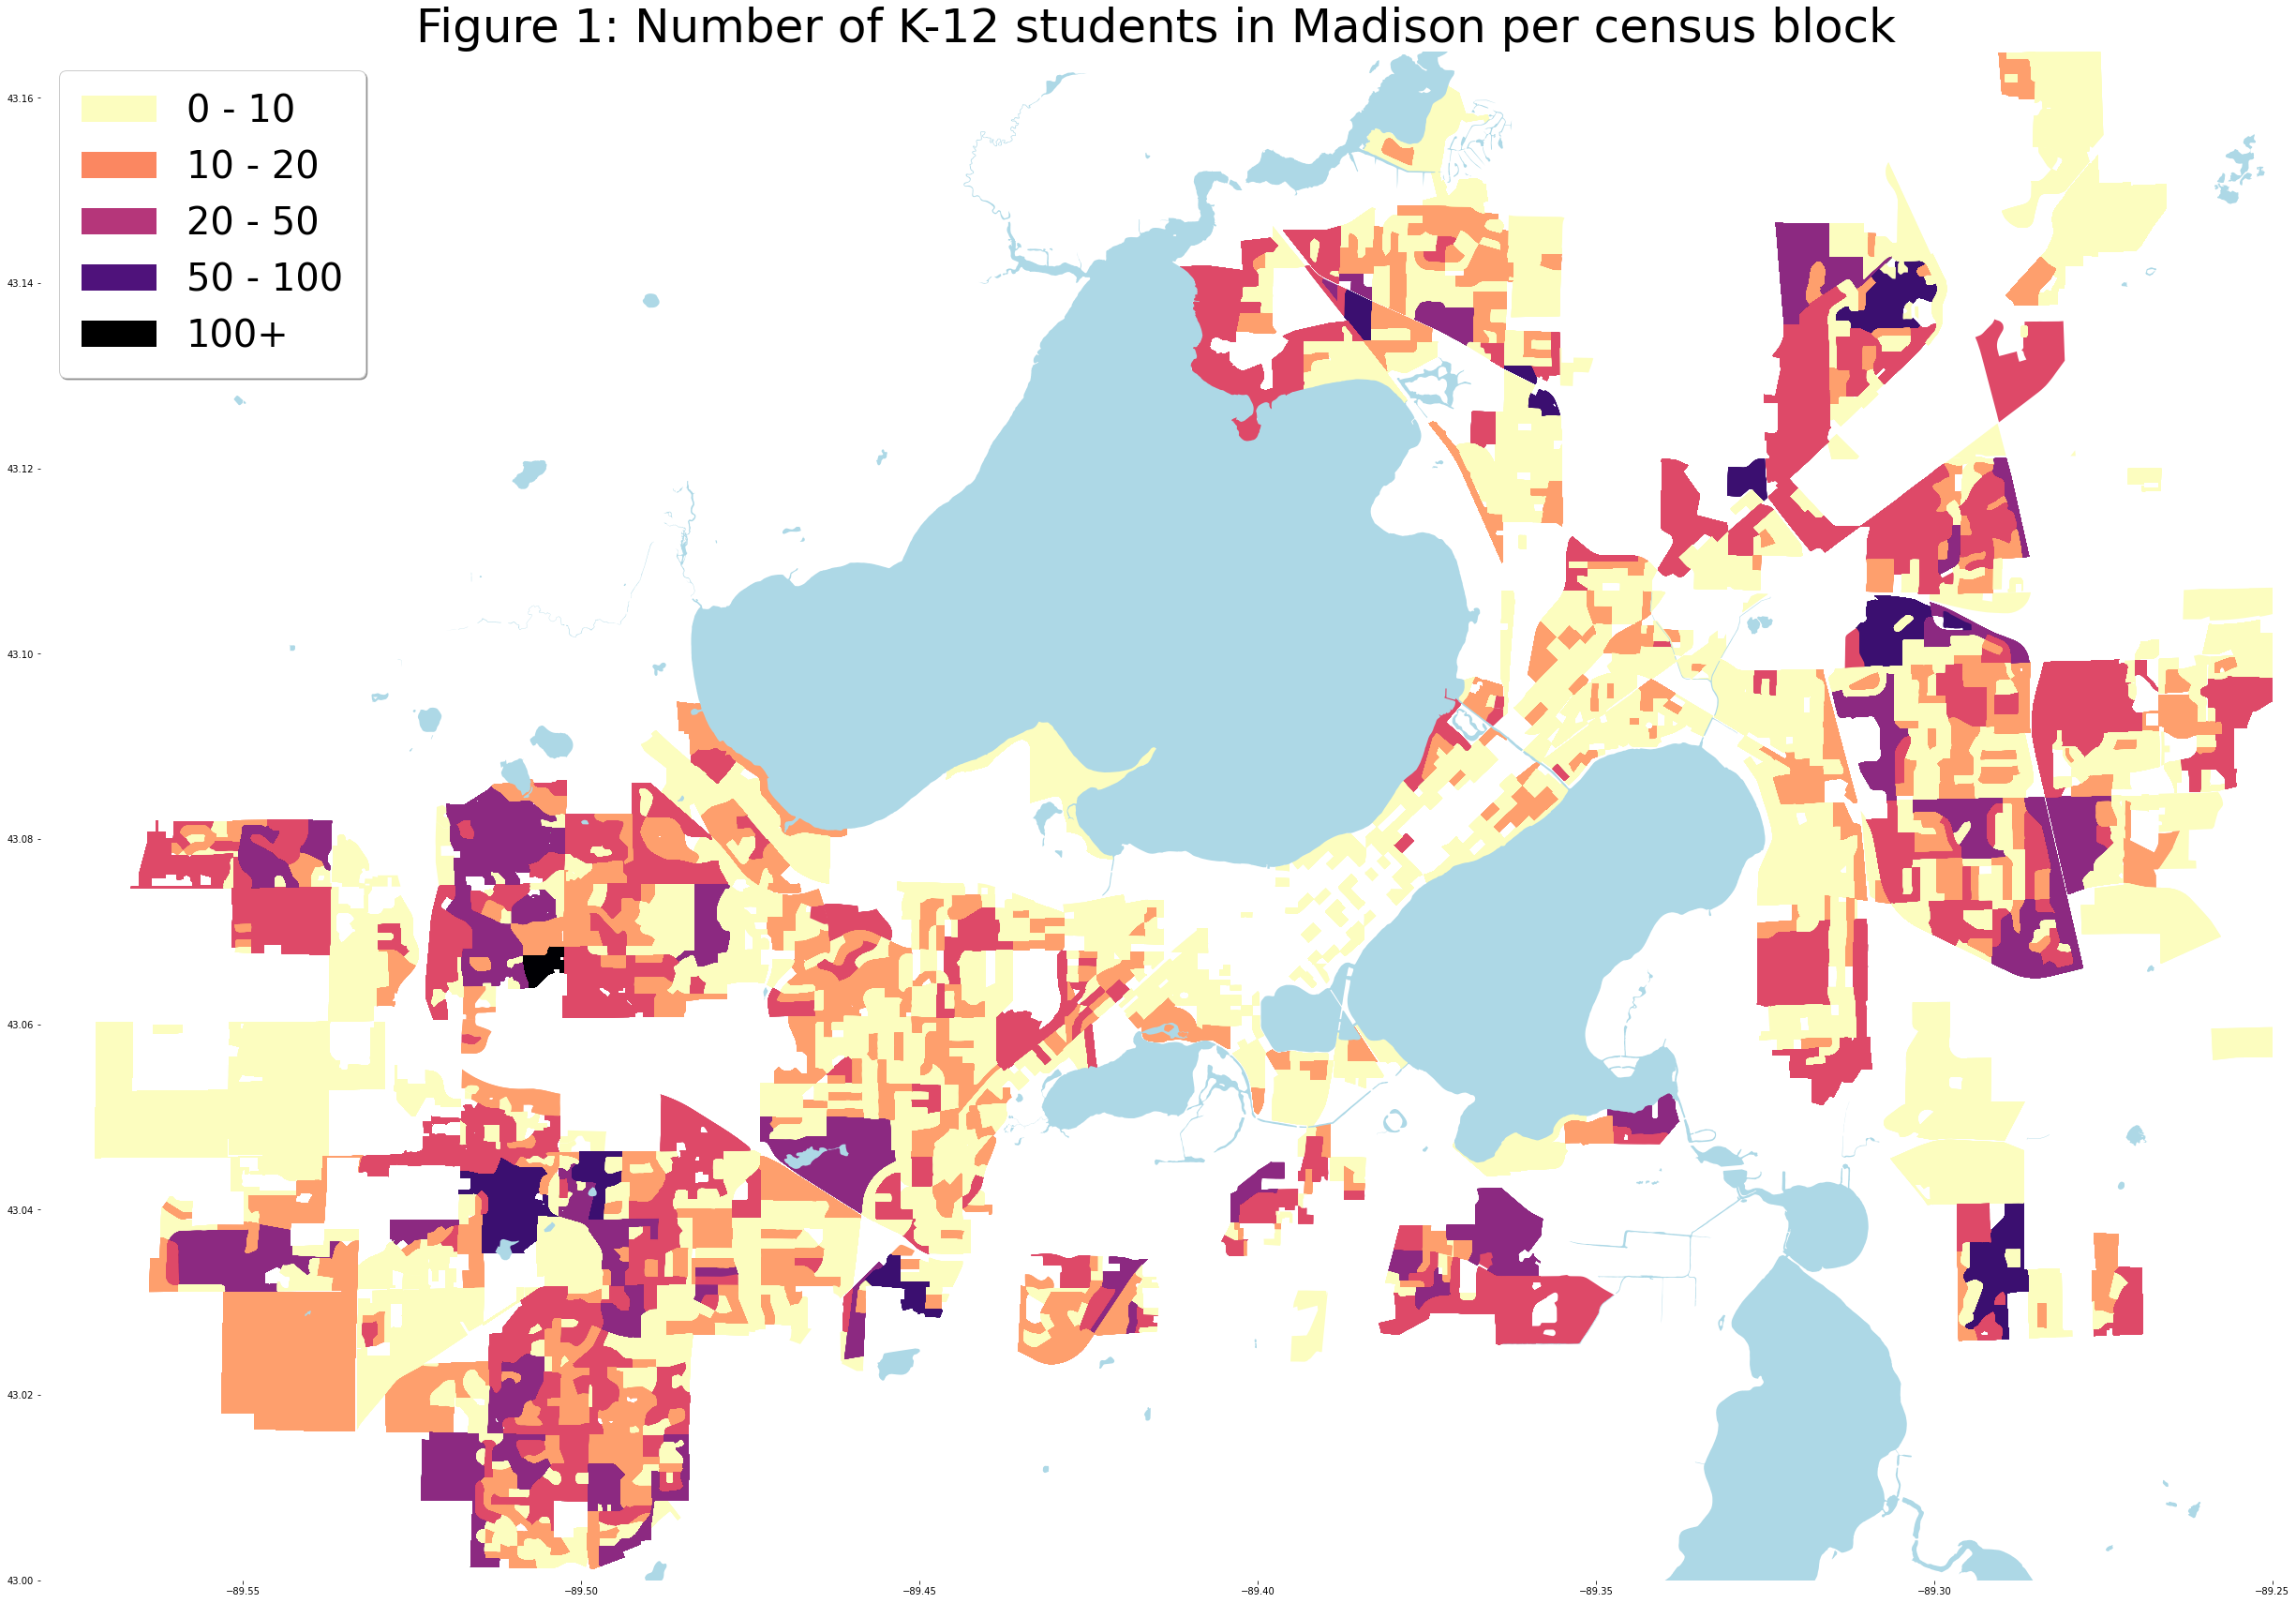

In [9]:
import matplotlib.patches as mpatches
import mapclassify as mc

madison = gpd.sjoin(K12_df, dane, how="right", op="within")
madison = madison[madison["Total_K-12_block"] >= 0]
bp = mc.UserDefined(madison["Total_K-12_block"], bins=[10, 20, 50, 100, 150])
ax = madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [10, 20, 50, 100, 150]},
                  k = 5, column='Total_K-12_block', cmap = 'magma_r')
lake_df.plot(ax=ax,color="lightblue")
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='100+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
# ax.axis('off')
ax.set_title("Figure 1: Number of K-12 students in Madison per census block", fontsize = 50)

## Linear Regression part

In [10]:
Condominium_bedroom_block = merged
Condominium_bedroom_block = Condominium_bedroom_block[Condominium_bedroom_block["PropertyUse"] != "2 Unit"]
Condominium_bedroom_block = Condominium_bedroom_block[Condominium_bedroom_block["PropertyUse"] != "Single family"]
Condominium_bedroom_block = Condominium_bedroom_block[Condominium_bedroom_block["PropertyUse"] != "3 To 7 Unit"]
Condominium_bedroom_block = Condominium_bedroom_block[["Area", "Address", "PropertyUse", "Bedrooms", "Total_K-12_block", "GEO_ID", "BlockBedrooms", "geometry", "area"]]
Condominium_bedroom_block["Apartment_bedroom"] = Condominium_bedroom_block.groupby(['GEO_ID']).Bedrooms.transform('sum')
Condominium_bedroom_block["House_bedroom"] = Condominium_bedroom_block["BlockBedrooms"] - Condominium_bedroom_block["Apartment_bedroom"]
Condominium_bedroom_block = Condominium_bedroom_block.drop_duplicates("GEO_ID")
Condominium_bedroom_block = Condominium_bedroom_block[["GEO_ID", "Apartment_bedroom", "House_bedroom"]]
total_bedroom_block = merged[["GEO_ID", "BlockBedrooms", "Total_K-12_block", "geometry", "area"]]
total_bedroom_block = total_bedroom_block.drop_duplicates("GEO_ID")
result = total_bedroom_block.merge(Condominium_bedroom_block, on="GEO_ID", how = "outer")
result["Apartment_bedroom"].fillna(0, inplace=True)
result["House_bedroom"].fillna(result["BlockBedrooms"], inplace=True)
result

,GEO_ID,BlockBedrooms,Total_K-12_block,geometry,area,Apartment_bedroom,House_bedroom
0,1000000US550250006002000,258,87,POINT (-89.45969 43.02980),0.039495,258.0,0.0
1,1000000US550250006002001,156,14,POINT (-89.45839 43.02956),0.016105,156.0,0.0
2,1000000US550250005044020,140,9,POINT (-89.53268 43.02574),0.020012,88.0,52.0
3,1000000US550250026032068,204,32,POINT (-89.29742 43.10858),0.009523,204.0,0.0
4,1000000US550250026032059,132,19,POINT (-89.29836 43.11047),0.017940,132.0,0.0
...,...,...,...,...,...,...,...
2281,1000000US550250114011030,50,1,POINT (-89.26252 43.09823),0.024686,50.0,0.0
2282,1000000US550250108005023,168,1,POINT (-89.50401 43.01107),0.018807,168.0,0.0
2283,1000000US550250108005038,82,3,POINT (-89.49956 43.00429),0.006566,82.0,0.0
2284,1000000US550250004053006,1086,5,POINT (-89.50790 43.04905),0.013436,1086.0,0.0


4.383149098503588


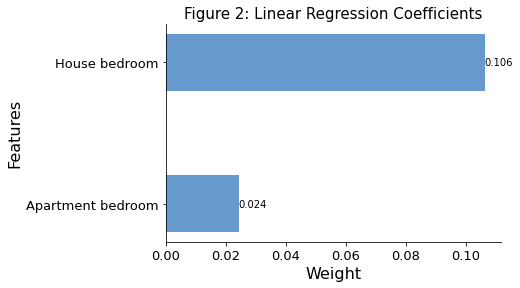

In [11]:
xcol = ["Apartment_bedroom", "House_bedroom"]
model1 = Pipeline([
            ("lr", LinearRegression())
        ])
model1.fit(result[xcol], result["Total_K-12_block"])

idx = [t.replace("_", " ") for t in xcol]
fig, ax = plt.subplots()
ax3 = ax.barh(range(len(idx)), model1["lr"].coef_, color='#6699CC', height = 0.4 )
ax.tick_params(labelsize=13)
for rect in ax3:
    w = rect.get_width()
    ax.text(w, rect.get_y()+rect.get_height()/2,
            "%.3f" % w, ha='left', va='center')
ax.set_yticks(range(len(idx)))
ax.set_yticklabels(idx)
ax.set_xlabel("Weight", fontsize=16)
ax.set_ylabel("Features", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Figure 2: Linear Regression Coefficients", fontsize=15)
print(model1["lr"].coef_[1] / model1["lr"].coef_[0])

In [13]:
# adjust the k-12 estimation using the new model
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]
ratio = model1["lr"].coef_[1] / model1["lr"].coef_[0]
result["BlockTotal_for_calculate"] = result["Apartment_bedroom"] + ratio * result["House_bedroom"]
estimator = result[["GEO_ID", "BlockTotal_for_calculate"]]
estimator_dict = dict(zip(estimator['GEO_ID'],estimator['BlockTotal_for_calculate']))
def estimate_K12(df):
    if df["PropertyUse"] not in ["2 Unit", "Single family", "3 To 7 Unit"]:
        return df["Total_K-12_block"] * df["Bedrooms"]/ estimator_dict[df["GEO_ID"]]
    if df["PropertyUse"] in ["2 Unit", "Single family", "3 To 7 Unit"]:
        return df["Total_K-12_block"] * df["Bedrooms"]/ estimator_dict[df["GEO_ID"]] * ratio


K12_df["K12_est"] = K12_df.apply(lambda  r:estimate_K12(r), axis=1)
K12_df

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms,K12_est
0,"Block 2000, Block Group 2, Census Tract 6, Dan...",2218 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45969 43.02980),800982.301653,466465.530860,294,87,1000000US550250006002000,0.039495,258,5.395349
1,"Block 2000, Block Group 2, Census Tract 6, Dan...",2322 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45995 43.02816),800912.471326,465869.120662,294,87,1000000US550250006002000,0.039495,258,5.395349
2,"Block 2000, Block Group 2, Census Tract 6, Dan...",2306 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45986 43.02871),800935.774665,466068.197512,294,87,1000000US550250006002000,0.039495,258,5.395349
3,"Block 2000, Block Group 2, Census Tract 6, Dan...",2226 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45973 43.02952),800970.644487,466366.051694,294,87,1000000US550250006002000,0.039495,258,5.395349
4,"Block 2000, Block Group 2, Census Tract 6, Dan...",2234 Allied Dr,8 unit Apartment,Commercial,16,POINT (-89.45978 43.02925),800959.021351,466267.246640,294,87,1000000US550250006002000,0.039495,258,5.395349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64317,"Block 3006, Block Group 3, Census Tract 4.05, ...",701 Harbor House Dr Unit P25,Condominium,Residential,2,POINT (-89.50790 43.04905),788099.224258,473494.448717,84,5,1000000US550250004053006,0.013436,1086,0.009208
64318,"Block 3006, Block Group 3, Census Tract 4.05, ...",701 Harbor House Dr Unit P26,Condominium,Residential,2,POINT (-89.50790 43.04905),788099.224258,473494.448717,84,5,1000000US550250004053006,0.013436,1086,0.009208
64319,"Block 3006, Block Group 3, Census Tract 4.05, ...",701 Harbor House Dr Unit P27,Condominium,Residential,2,POINT (-89.50790 43.04905),788099.224258,473494.448717,84,5,1000000US550250004053006,0.013436,1086,0.009208
64320,"Block 3006, Block Group 3, Census Tract 4.05, ...",701 Harbor House Dr Unit P28,Condominium,Residential,2,POINT (-89.50790 43.04905),788099.224258,473494.448717,84,5,1000000US550250004053006,0.013436,1086,0.009208


## Top 50 apartments table

In [14]:
# sort by the number of K-12 children estimation grouped by Point.
K12_df["K-12_by_point"] = K12_df.groupby(by=["XCoord", "YCoord"])["K12_est"].transform('sum')
point_order = K12_df.sort_values(by=['K-12_by_point'], ascending=False)

In [25]:
Top_50 = K12_df
Top_50 = Top_50[Top_50["PropertyUse"] != "2 Unit"]
Top_50 = Top_50[Top_50["PropertyUse"] != "Single family"]
Top_50 = Top_50[Top_50["PropertyUse"] != "3 To 7 Unit"]
Top_50["Apartment_bedrooms"] = Top_50.groupby(["XCoord", "YCoord"]).Bedrooms.transform(sum)
Top_50 = Top_50.drop_duplicates("geometry")
Top_50 = Top_50.sort_values(by=['K-12_by_point'], ascending=False)
Top_50 = Top_50[:50]
Top_50 = Top_50[["Area", "Address", "geometry", "Apartment_bedrooms", "K-12_by_point", "XCoord", "YCoord", "GEO_ID"]]
total_50 = Top_50[["Address", "Apartment_bedrooms", "K-12_by_point"]]
total_50.to_csv("Top50_Apartments.csv", index = False)
total_50.head()

,Address,Apartment_bedrooms,K-12_by_point
7828,225 N Thompson Dr,632,109.000000
134,2002 Elka Ln,144,63.614067
4559,501 Northport Dr,256,58.000000
7979,57 Northridge Ter,96,51.121890
57647,312 East Bluff,441,44.464498


In [26]:
Top_50 = Top_50.reset_index()
Top_50 = Top_50[["Address", "GEO_ID", "Apartment_bedrooms", "K-12_by_point", "geometry"]]

In [134]:
Top_50.iloc[49]

Address                                          3702 Packers Ave
GEO_ID                                   1000000US550250024021020
Apartment_bedrooms                                            128
K-12_by_point                                            15.47907
geometry              POINT (-89.3557985696911 43.13358178313035)
Name: 49, dtype: object

In [135]:
pd.set_option('display.max_rows', None)
block_with_apartment[block_with_apartment["GEO_ID"] == "1000000US550250024021020"]

,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,GEO_ID,area
18102,3702 Packers Ave,64 unit Apartment,Commercial,128,POINT (-89.35580 43.13358),828733.630900,504299.793036,1000000US550250024021020,0.015539
745,3709 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35633 43.13435),828591.802845,504578.930153,1000000US550250024021020,0.015539
9826,3613 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35632 43.13371),828595.271374,504346.037142,1000000US550250024021020,0.015539
21141,2001 Tennyson Ln,4 unit Apartment,Residential,8,POINT (-89.35633 43.13455),828590.364613,504651.634752,1000000US550250024021020,0.015539
31260,3701 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35632 43.13392),828594.178064,504423.195454,1000000US550250024021020,0.015539
47848,3605 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35631 43.13328),828597.321007,504191.087582,1000000US550250024021020,0.015539
51383,3705 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35633 43.13413),828592.771616,504500.823327,1000000US550250024021020,0.015539
60574,3710 Packers Ave Unit 101,Condominium,Residential,1,POINT (-89.35581 43.13442),828729.074564,504604.243671,1000000US550250024021020,0.015539
60575,3710 Packers Ave Unit 103,Condominium,Residential,1,POINT (-89.35581 43.13442),828729.074564,504604.243671,1000000US550250024021020,0.015539
60576,3710 Packers Ave Unit 102,Condominium,Residential,2,POINT (-89.35581 43.13442),828729.074564,504604.243671,1000000US550250024021020,0.015539


## Plots

#### cumulative children live in apartments

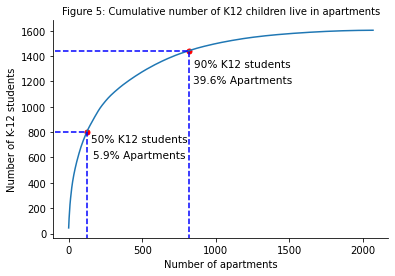

In [30]:
Buildings = K12_df[["GEO_ID", "PropertyUse", "geometry", "Area", "K-12_by_point"]]
Buildings = Buildings[(Buildings["PropertyUse"] == "Condominium") | (Buildings["PropertyUse"] == "2 unit Apartment")
                                   | (Buildings["PropertyUse"] == "3 unit Apartment") | (Buildings["PropertyUse"] == "4 unit Apartment")
                                   | (Buildings["PropertyUse"] == "5 unit Apartment") | (Buildings["PropertyUse"] == "6 unit Apartment")
                                   | (Buildings["PropertyUse"] == "7 unit Apartment")]
Buildings = Buildings.drop_duplicates("geometry")
Buildings = Buildings.sort_values(by=['K-12_by_point'], ascending=False)
K12_data = np.array(Buildings["K-12_by_point"].tolist())
cumulative = pd.DataFrame(K12_data.cumsum())
plt.plot(cumulative)
plt.axis('tight')
plt.title("Figure 5: Cumulative number of K12 children live in apartments", fontsize=10)
plt.xlabel("Number of apartments")
plt.ylabel("Number of K-12 students")
x_50 = 123
y_50 = 801.69
plt.scatter(x_50, y_50, s=25, c='r')
plt.plot([-90, x_50], [y_50, y_50], c='b', linestyle='--')
plt.plot([123, x_50], [-50, y_50], c='b', linestyle='--')
plt.text(x_50+360, y_50-100, '50% K12 students', ha='center', va='bottom', fontsize=10.5)  # horizontal alignment
plt.text(x_50+360, y_50-220, '5.9% Apartments', ha='center', va='bottom', fontsize=10.5)

x_90 = 820
y_90 = 1443.39
plt.scatter(x_90, y_90, s=25, c='r')
plt.plot([-90, x_90], [y_90, y_90], c='b', linestyle='--')
plt.plot([x_90, x_90], [-50, y_90], c='b', linestyle='--')
plt.text(x_90+360, y_90-150, '90% K12 students', ha='center', va='bottom', fontsize=10.5)  # horizontal alignment
plt.text(x_90+360, y_90-270, '39.6% Apartments', ha='center', va='bottom', fontsize=10.5)
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

In [19]:
cumulative[0].iloc[50]

543.459359379267

## Use the linear regression coef to improve the estimate


In [20]:
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]

result["K12_in_apt"] = result["Total_K-12_block"] / (result["House_bedroom"] + result["Apartment_bedroom"] * (apt_pro/house_pro)) * (result["Apartment_bedroom"] * (apt_pro/house_pro))
result["K12_in_other"] = result["Total_K-12_block"] - result["K12_in_apt"]
result['apt_density'] = result['K12_in_apt'] / result['area']
result['other_density'] = result['K12_in_other'] / result['area']
result.head()

,GEO_ID,BlockBedrooms,Total_K-12_block,geometry,area,Apartment_bedroom,House_bedroom,BlockTotal_for_calculate,K12_in_apt,K12_in_other,apt_density,other_density
0,1000000US550250006002000,258,87,POINT (-89.45969 43.02980),0.039495,258.0,0.0,258.000000,87.000000,0.000000e+00,2202.819568,0.000000e+00
1,1000000US550250006002001,156,14,POINT (-89.45839 43.02956),0.016105,156.0,0.0,156.000000,14.000000,-1.776357e-15,869.268541,-1.102951e-13
2,1000000US550250005044020,140,9,POINT (-89.53268 43.02574),0.020012,88.0,52.0,315.923753,2.506934,6.493066e+00,125.271428,3.244583e+02
3,1000000US550250026032068,204,32,POINT (-89.29742 43.10858),0.009523,204.0,0.0,204.000000,32.000000,0.000000e+00,3360.385726,0.000000e+00
4,1000000US550250026032059,132,19,POINT (-89.29836 43.11047),0.017940,132.0,0.0,132.000000,19.000000,0.000000e+00,1059.111662,0.000000e+00


In [21]:
lake_df = gpd.read_file("lakes.zip")

### The density plot of k12 in apartment

Text(0.5, 1.0, 'Figure 4: Number of K-12 students living in apartments per square mile in each block')

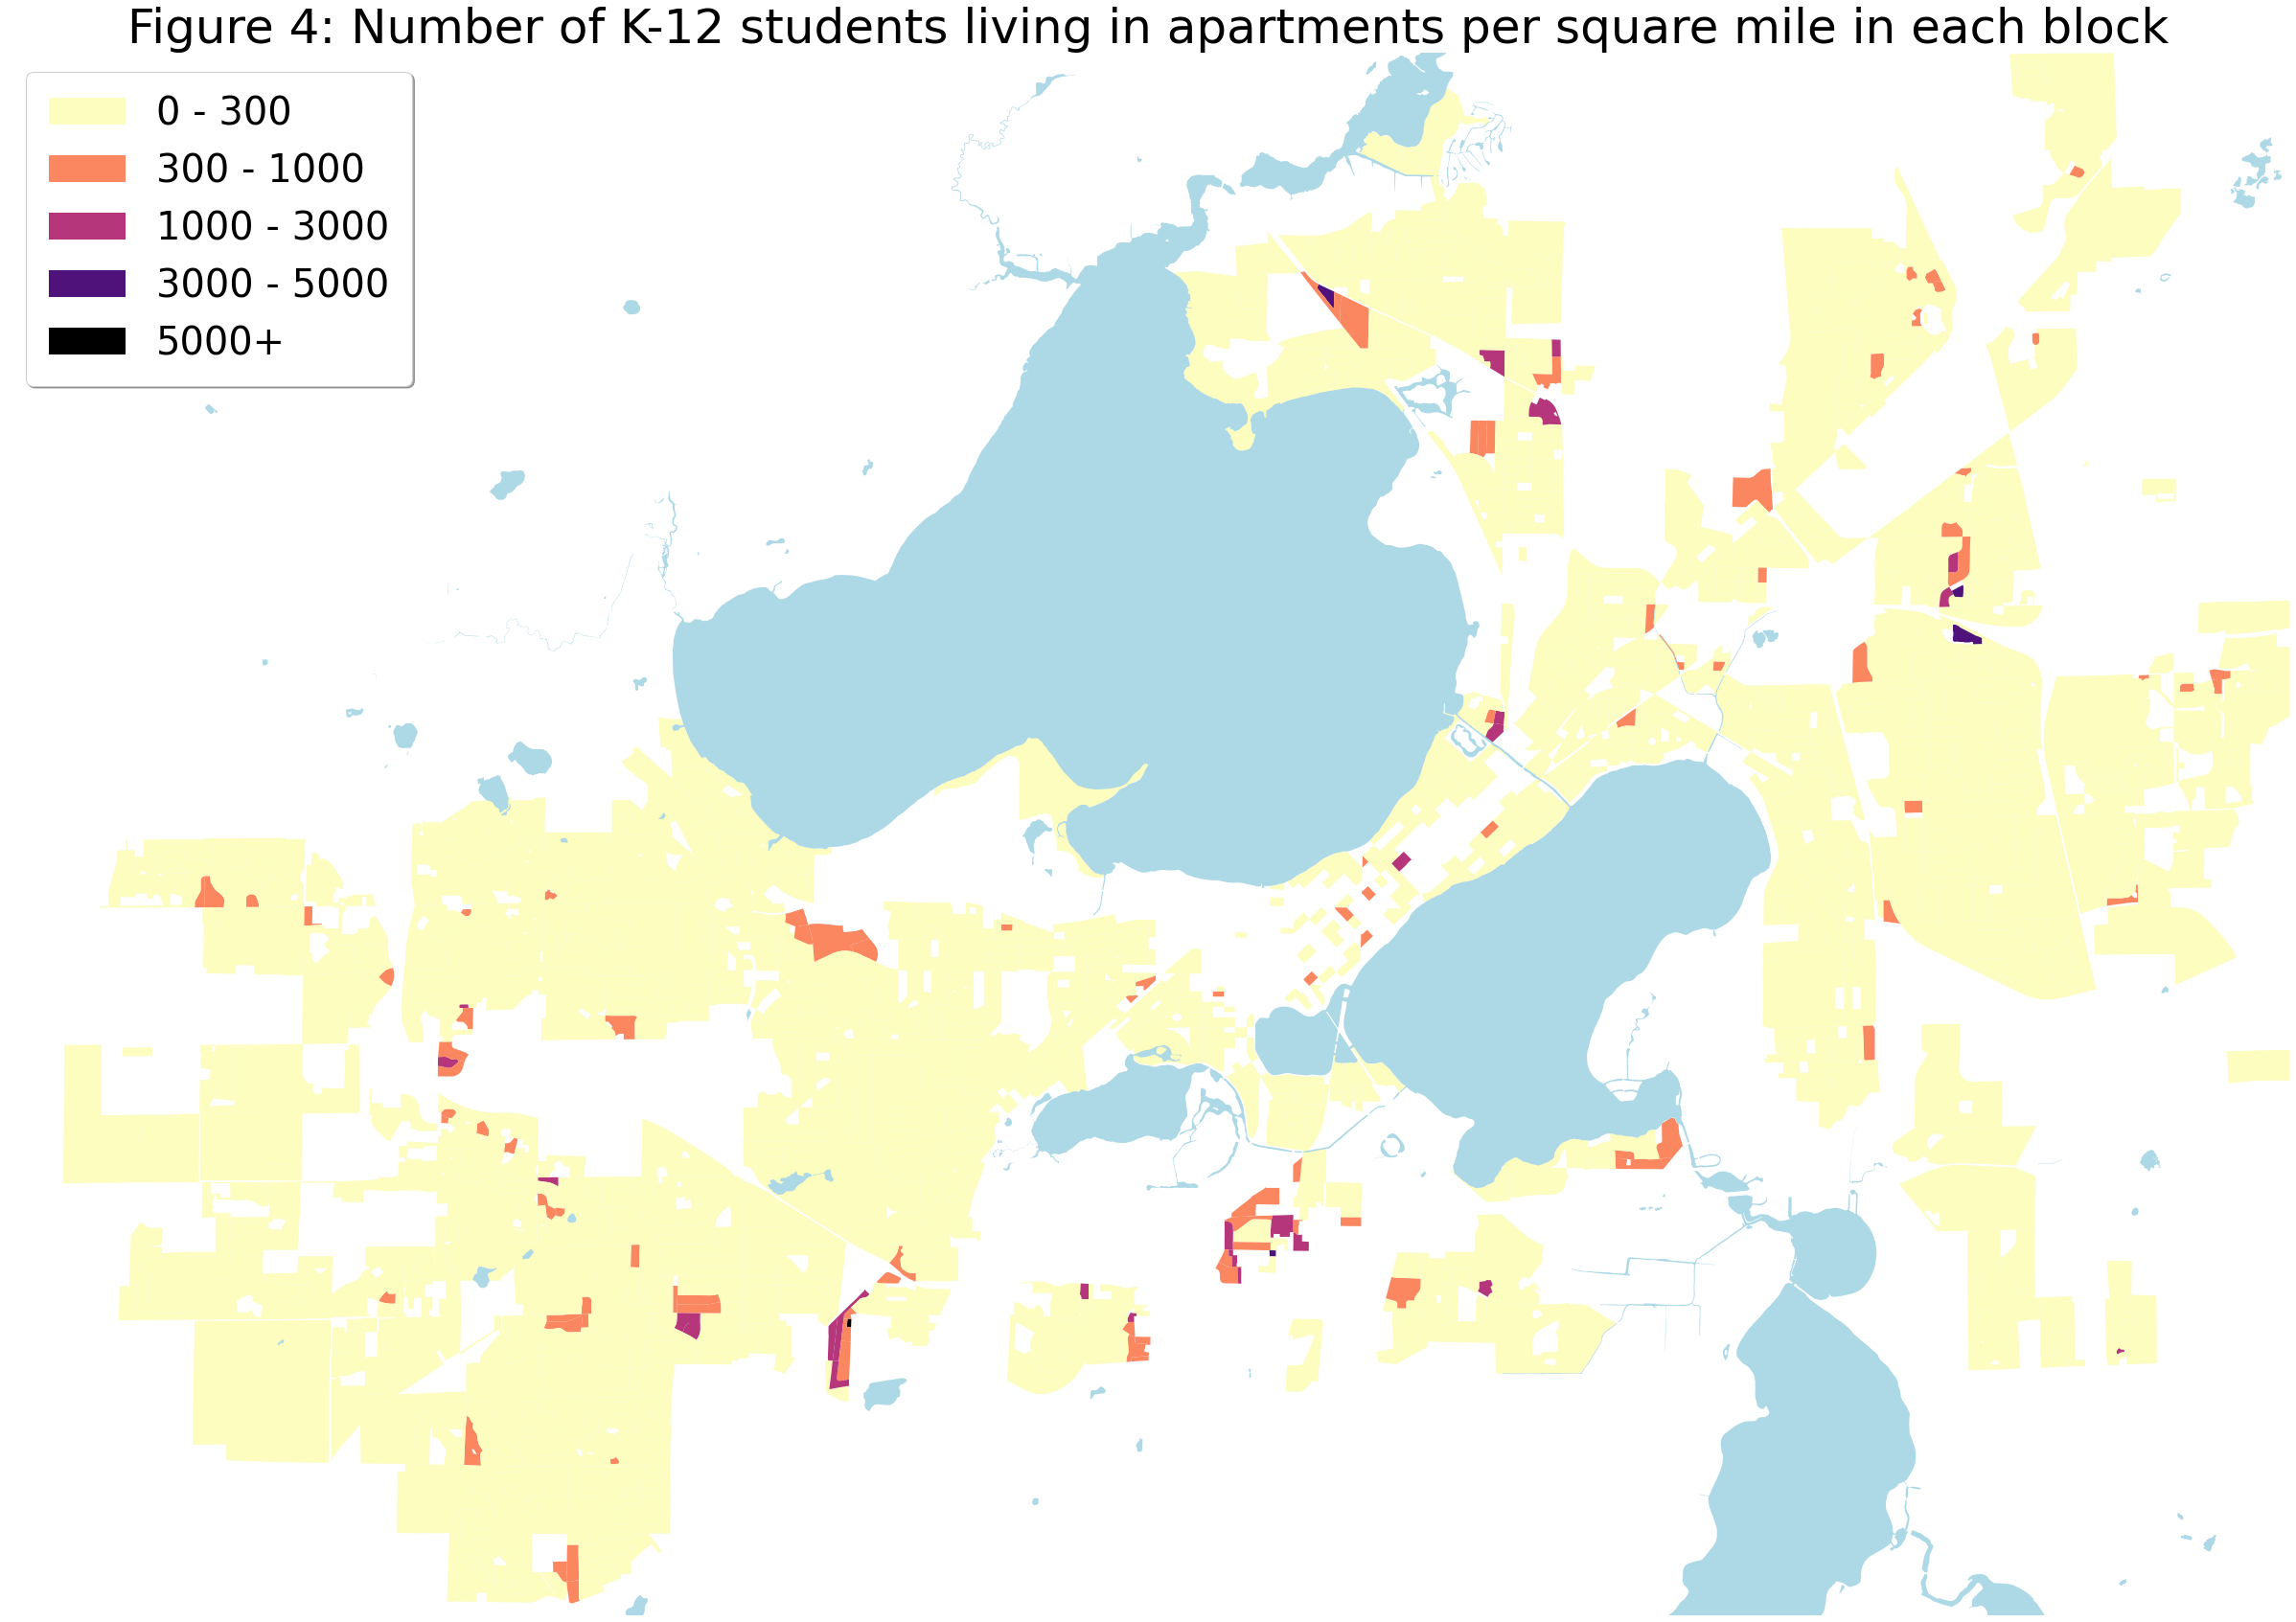

In [29]:
result = gpd.GeoDataFrame(result)
lake_df = lake_df.to_crs(result.crs)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
apartment_madison = apartment_madison[["geometry", "apt_density"]]
apartment_madison = apartment_madison.dropna()

bp = mc.UserDefined(apartment_madison["apt_density"], bins=[300, 1000, 3000, 5000, 50000])
ax = apartment_madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [300, 1000, 3000, 5000, 50000]}, k = 5, column='apt_density', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')

bins = bp.bins
bins = np.insert(bins, 0, 0)
bp
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='5000+')]

ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
ax.axis('off')
ax.set_title("Figure 4: Number of K-12 students living in apartments per square mile in each block", fontsize = 50)

### The density plot of k12 in other house

Text(0.5, 1.0, 'Figure 3: Number of K-12 students living in houses per square mile in each block')

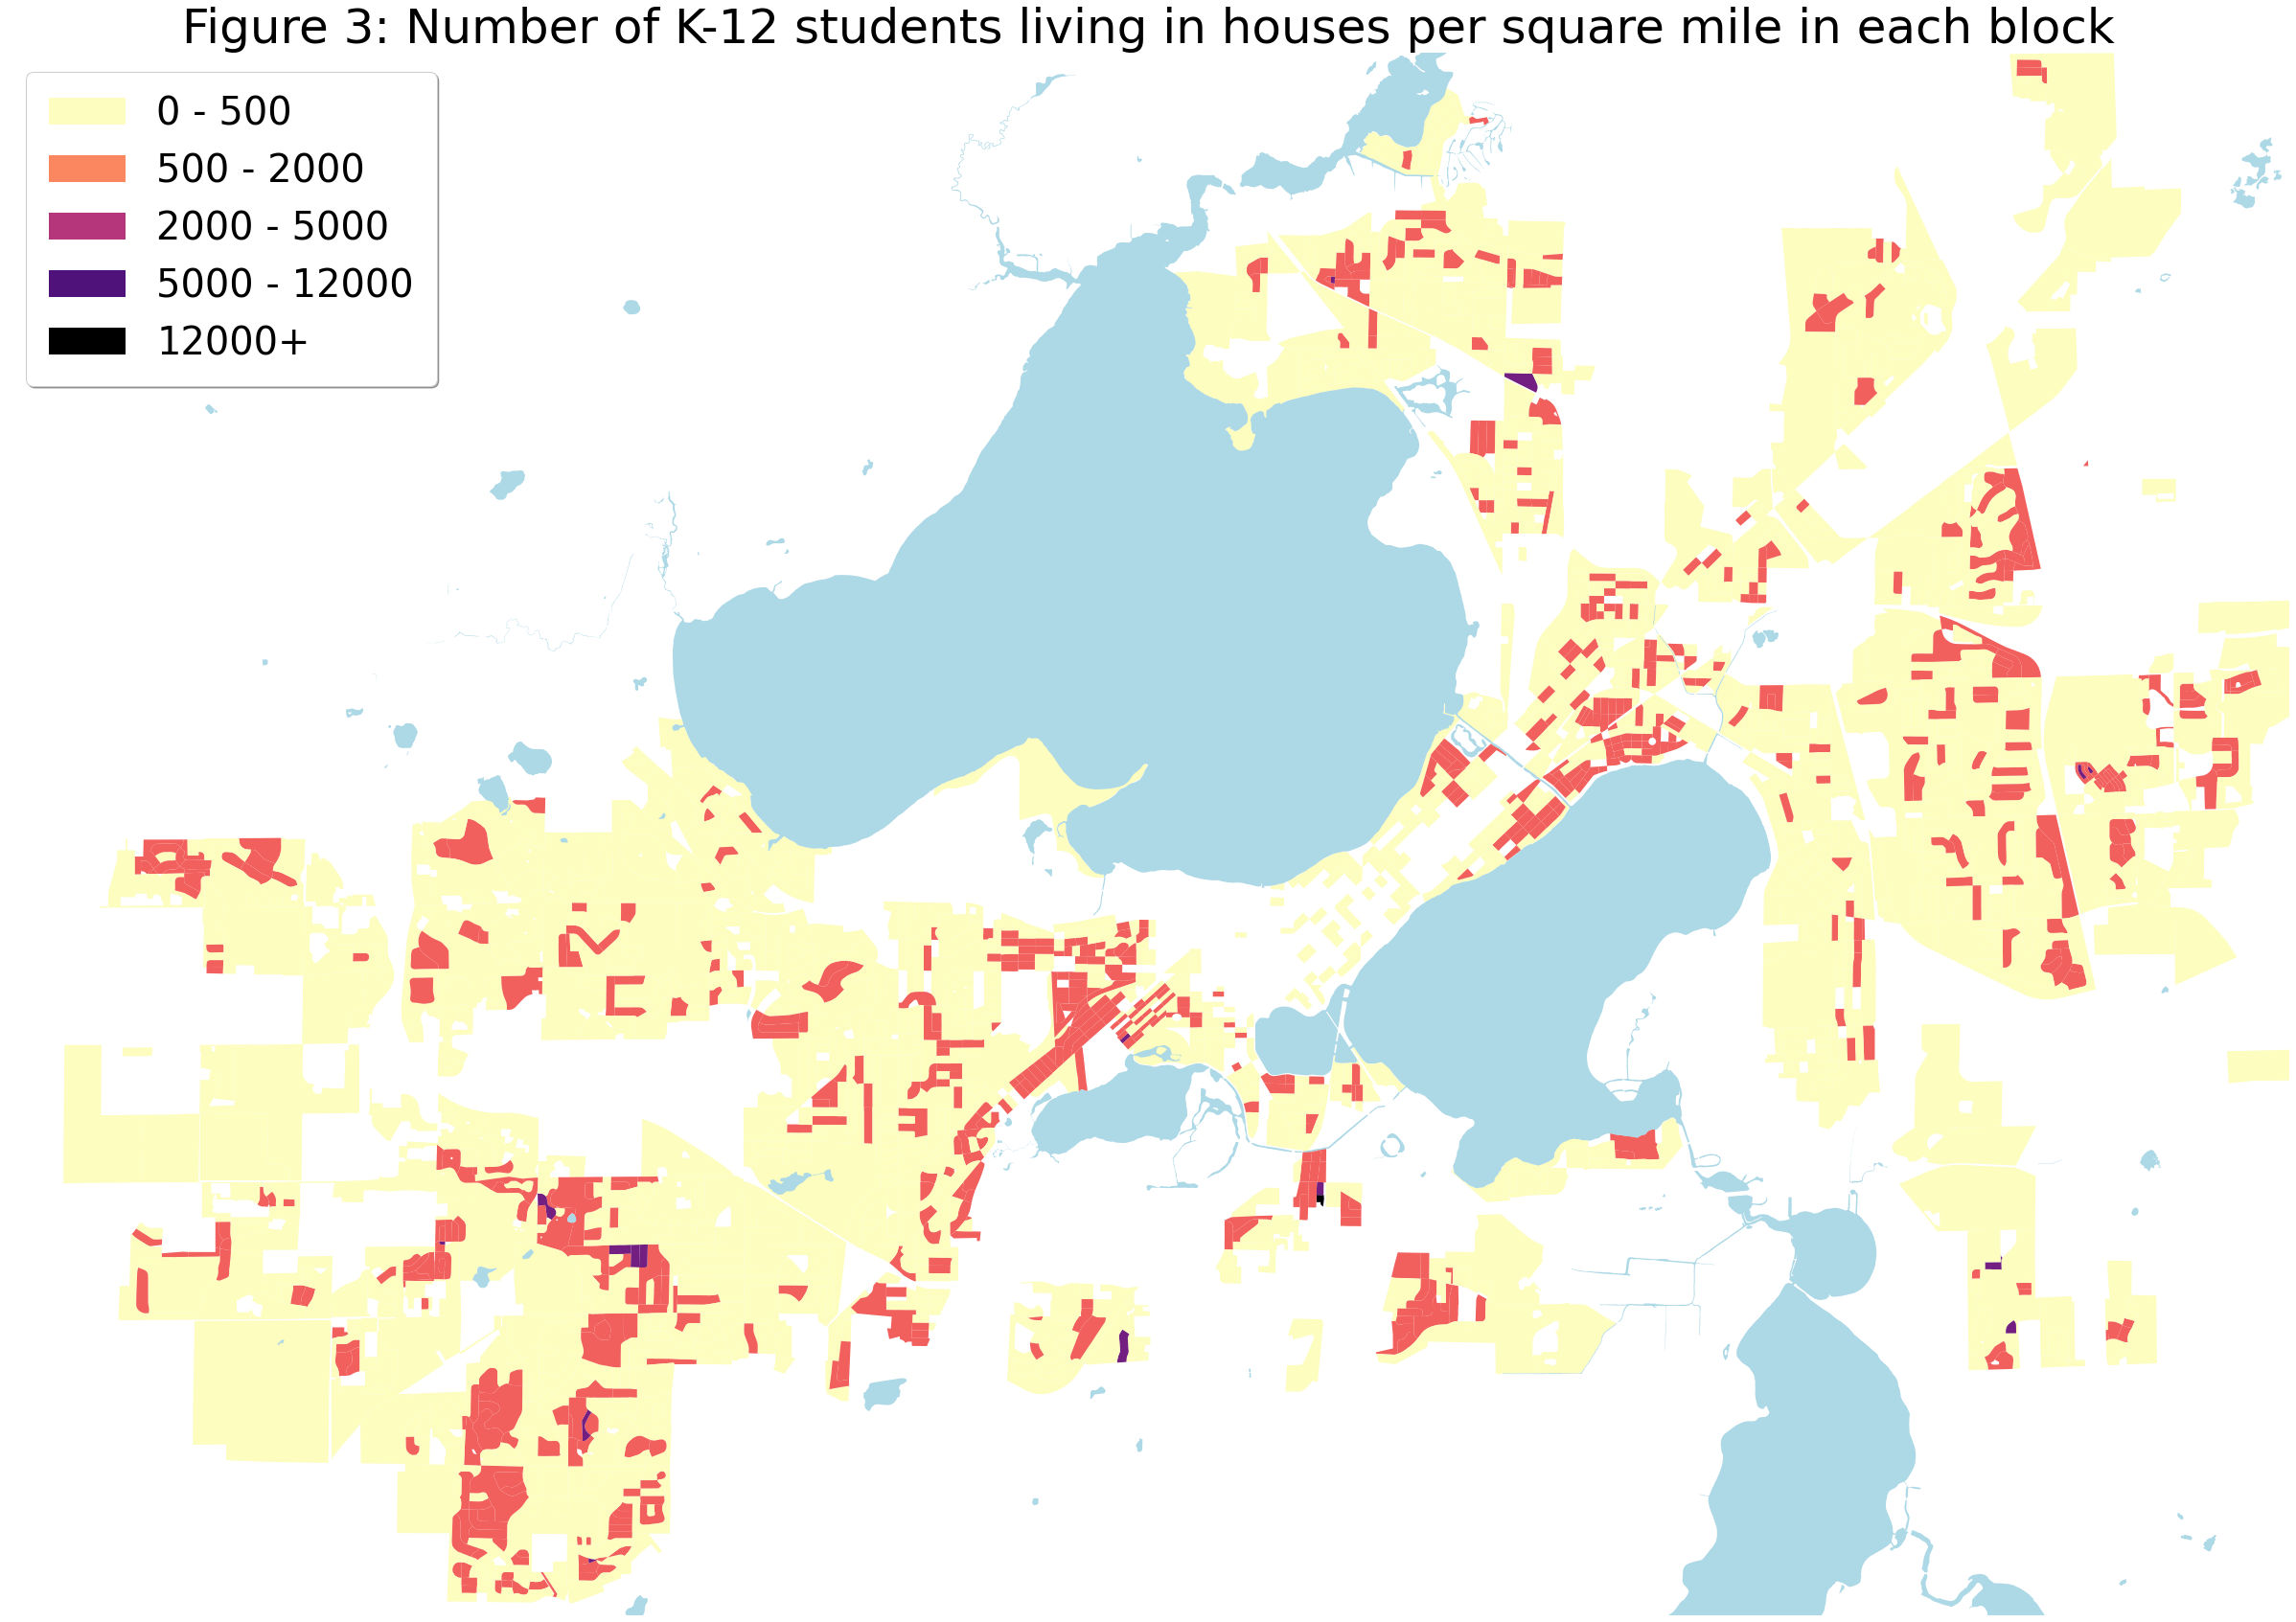

In [28]:
result = gpd.GeoDataFrame(result)
house_madison = gpd.sjoin(result, dane, how="right", op="within")
house_madison = house_madison[["geometry", "other_density"]]
house_madison = house_madison.dropna()
bp = mc.UserDefined(apartment_madison["apt_density"], bins=[500, 2000, 5000, 12000, 50000])
ax = house_madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [500, 2000, 5000, 12000, 50000]}, k = 5, column='other_density', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='12000+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
ax.axis('off')
ax.set_title("Figure 3: Number of K-12 students living in houses per square mile in each block", fontsize = 50)

## The density plot of k12 in each blocks

Text(0.5, 1.0, 'Figure 1: Number of K-12 students in Madison per block per square mile')

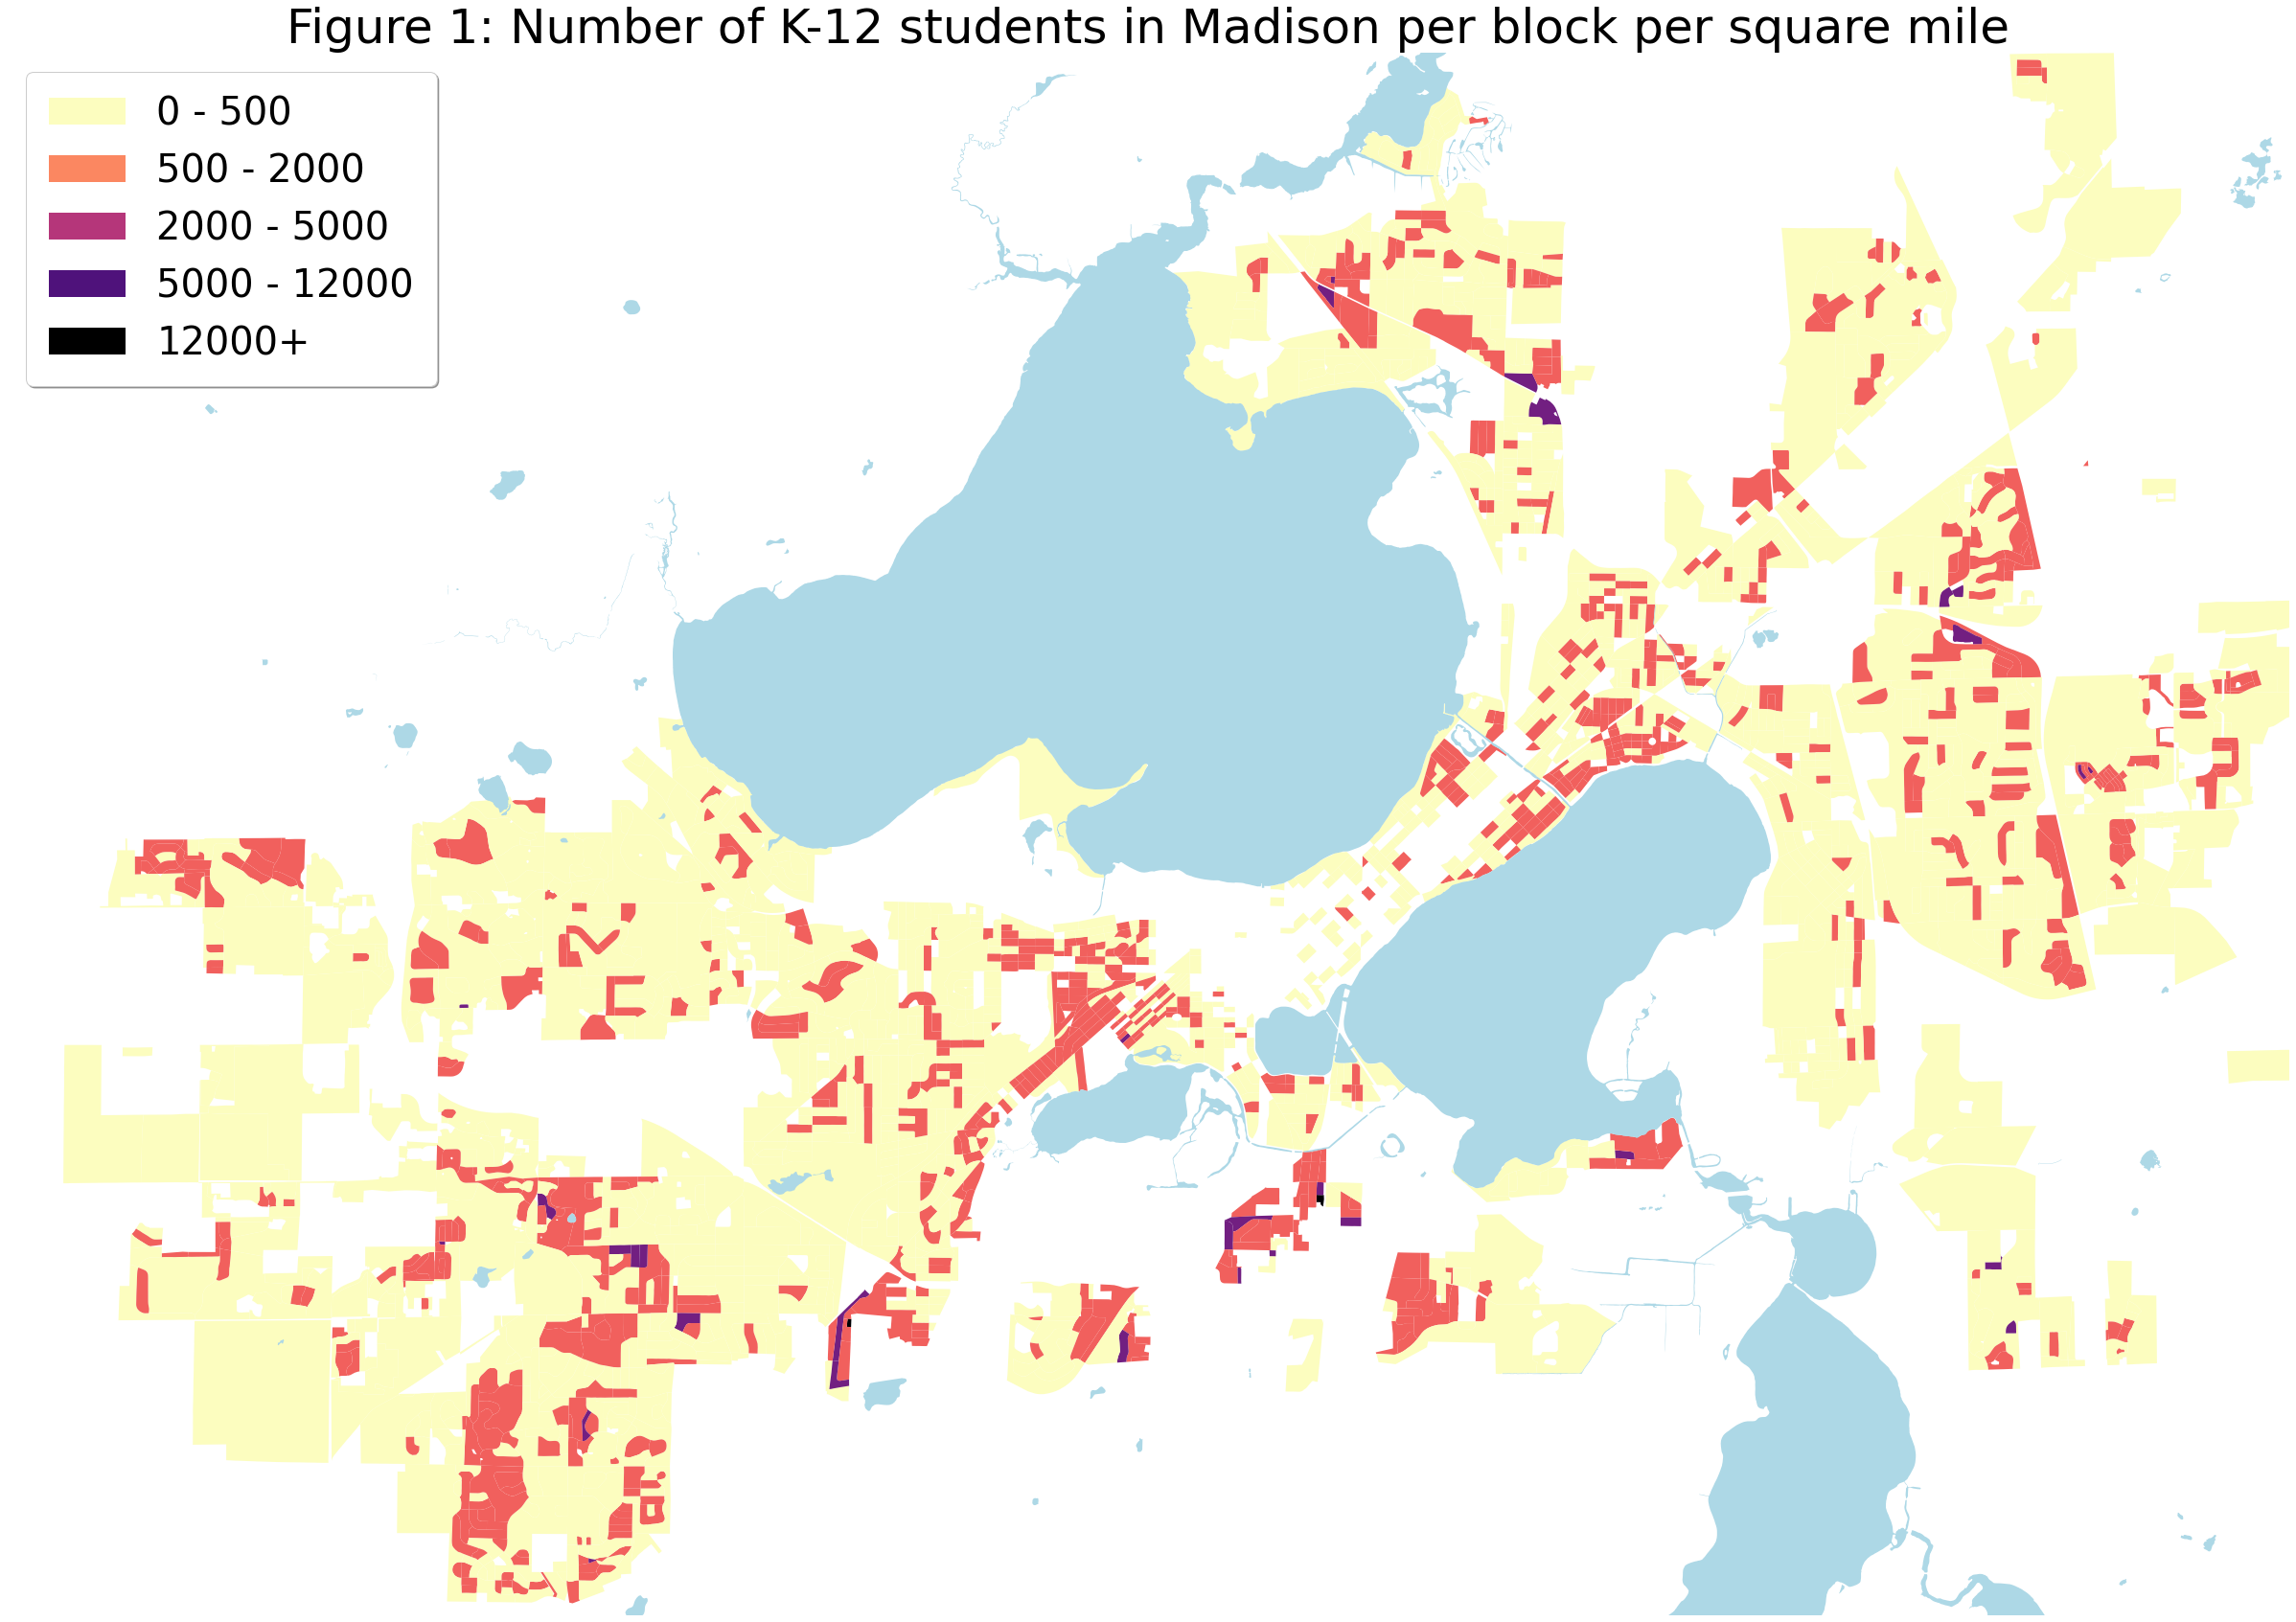

In [24]:
result["block_density"] = result['Total_K-12_block'] / result['area']
result = gpd.GeoDataFrame(result)
madison = gpd.sjoin(result, dane, how="right", op="within")
madison = madison[["geometry", "block_density"]]
madison = madison.dropna()
bp = mc.UserDefined(apartment_madison["apt_density"], bins=[500, 2000, 5000, 12000, 50000])
ax = madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [500, 2000, 5000, 12000, 50000]}, k = 5, column='block_density', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='12000+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
ax.axis('off')
ax.set_title("Figure 1: Number of K-12 students in Madison per block per square mile", fontsize = 50)

In [142]:
data = pd.read_csv("Top50_Apartments_update.csv")
data["#Bedrooms"] = data["#Bedrooms"].astype(int)
data["#K12Estimates"] = data["#K12Estimates"].astype(int)
data

,Address,#Bedrooms,#K12Estimates
0,225 N Thompson Dr,632,109
1,2002 Elka Ln,144,63
2,501 Northport Dr,256,58
3,57 Northridge Ter,96,51
4,210-236 & 301-349 & 401-448 & 501-544 East Bluff,441,44
5,2501 City View Dr,130,40
6,201 N Walbridge Ave,220,40
7,3502 Straubel St,96,39
8,302 Parkwood Ln,544,38
9,2801 Dryden Dr,80,35


In [143]:
data["Est K12 per bedroom"] = data["#K12Estimates"] / data["#Bedrooms"]

In [144]:
data

,Address,#Bedrooms,#K12Estimates,Est K12 per bedroom
0,225 N Thompson Dr,632,109,0.172468
1,2002 Elka Ln,144,63,0.437500
2,501 Northport Dr,256,58,0.226562
3,57 Northridge Ter,96,51,0.531250
4,210-236 & 301-349 & 401-448 & 501-544 East Bluff,441,44,0.099773
5,2501 City View Dr,130,40,0.307692
6,201 N Walbridge Ave,220,40,0.181818
7,3502 Straubel St,96,39,0.406250
8,302 Parkwood Ln,544,38,0.069853
9,2801 Dryden Dr,80,35,0.437500


In [145]:
data.to_csv("Top50_final_result.csv", index = False)